# **Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.3.2 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system. The tools installation can be carried out inside the Jupyter Notebook of the Colab. One important note is that if you are new in Spark, it is better to avoid Spark 2.4.0 version since some people have already complained about its compatibility issue with python. 
Follow the steps to install the dependencies:

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.3.3/spark-2.3.3-bin-hadoop2.7.tgz
!tar xf spark-2.3.3-bin-hadoop2.7.tgz
!pip install -q findspark

Now that you installed Spark and Java in Colab, it is time to set the environment path which enables you to run Pyspark in your Colab environment. Set the location of Java and Spark by running the following code:

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.3-bin-hadoop2.7"

Run a local spark session to test your installation:

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
sqlSession = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [7]:
nums = sc.parallelize([1,2,3,4])
squared = nums.map(lambda x: x * x).collect()
for num in squared:
  print (num)

1
4
9
16


Upload "auto-data.csv"

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving auto-data.csv to auto-data.csv
User uploaded file "auto-data.csv" with length 11547 bytes


# **Import libraries** 

In [0]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

import math
import pandas as pd
import matplotlib.pylab as plt

# **Load and prepare data**



In [10]:
autoData = sc.textFile("auto-data.csv")
autoData.cache()

auto-data.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

Remove header

In [11]:
firstLine = autoData.first()
dataLines = autoData.filter(lambda x: x != firstLine)
dataLines.count()

197

# **Convert line to vector row**

In [0]:
def transformToNumeric( inputStr) :
    attList=inputStr.split(",")

    doors = 1.0 if attList[3] =="two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    #Filter out columns not wanted at this stage
    values= Row(DOORS= doors, \
                     BODY=float(body),  \
                     HP=float(attList[7]),  \
                     RPM=float(attList[8]),  \
                     MPG=float(attList[9])  \
                     )
    return values

In [14]:
autoMap = dataLines.map(transformToNumeric)
autoMap.persist()
autoMap.collect()

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=60.0, MPG=38.0, RPM=5500.0),
 Row(BODY=1.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=5200.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=2.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=2.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=70.0, MPG=38.0, RPM=5400.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=31.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=58.0, MPG=49.0, RPM=4800.0),
 Row(BODY=2.0,

In [16]:
autoDf = sqlSession.createDataFrame(autoMap)
autoDf.show()

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



# **Centering and scaling**

To perform this every value should be subtracted from that column's mean and divided by its Std. Deviation.

In [0]:
summStats=autoDf.describe().toPandas()
meanValues=summStats.iloc[1,1:5].values.tolist()
stdValues=summStats.iloc[2,1:5].values.tolist()

Place the means and std.dev values in a broadcast variable

In [0]:
bcMeans=sc.broadcast(meanValues)
bcStdDev=sc.broadcast(stdValues)

In [0]:
def centerAndScale(inRow) :
    global bcMeans
    global bcStdDev
    
    meanArray=bcMeans.value
    stdArray=bcStdDev.value

    retArray=[]
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) /\
            float(stdArray[i]) )
    return Vectors.dense(retArray)

In [21]:
csAuto = autoDf.rdd.map(centerAndScale)
csAuto.collect()

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.8928, 1.9956]),
 DenseVector([0.9337, -1.145, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -1.2116, 3.7043]),
 DenseVector([0.9337, 0.869, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.7334, 0.753]),
 DenseVector([-1.0656, 0.869, -0.8928, 1.9956]),
 DenseVector([-1.0656, -

# **Create a Spark Data Frame**

In [22]:
autoRows=csAuto.map( lambda f:Row(features=f))
autoDf = sqlSession.createDataFrame(autoRows)

autoDf.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



# **Clustering**

In [23]:
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(autoDf)
predictions = model.transform(autoDf)
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
+--------------------+----------+
only showing top 20 rows



# **Plotting the results**

In [0]:
def unstripData(instr) :
    return ( instr["prediction"], instr["features"][0], \
        instr["features"][1],instr["features"][2],instr["features"][3])

In [29]:
unstripped=predictions.rdd.map(unstripData)
predList=unstripped.collect()
predPd = pd.DataFrame(predList)

[(1, 0.9336716814805123, -1.1449709581789205, -0.9193621542317812, 0.908331819324846), (1, 0.9336716814805123, -1.1449709581789205, -1.477291042607442, 3.3936286027553275), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 0.7530007703604409), (1, 0.9336716814805123, -1.1449709581789205, -1.1053384503570014, 1.5296560151824663), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 1.8403181131112765), (1, 0.9336716814805123, -1.1449709581789205, -1.1584745349642074, 1.9956491620756815), (0, -1.0656035495158018, -1.1449709581789205, -0.9193621542317812, 0.908331819324846), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 1.8403181131112765), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 1.8403181131112765), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 0.908331819324846), (1, 0.9336716814805123, -1.1449709581789205, -0.9459301965353841, 0.908331819324846), (1, 0.9336716814805123, 0.8689511736179311, -0

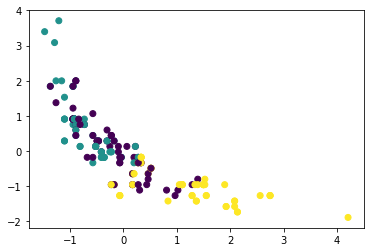

In [36]:
plt.cla()
plt.scatter(predPd[3],predPd[4], c=predPd[0])